In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sol = pd.read_csv('SampleSubmission.csv')

In [4]:
print(train.shape)
print(test.shape)

(4990, 13)
(3532, 12)


In [5]:
train.head()

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type,Item_Store_Returns
0,DRA12,BABATUNJI010,DRA12_BABATUNJI010,11.6,Low Sugar,0.068535,Soft Drinks,357.54,2005,NaN,Cluster 3,Grocery Store,709.08
1,DRA12,BABATUNJI013,DRA12_BABATUNJI013,11.6,Low Sugar,0.040912,Soft Drinks,355.79,1994,High,Cluster 3,Supermarket Type1,6381.69
2,DRA12,BABATUNJI017,DRA12_BABATUNJI017,11.6,Low Sugar,0.041178,Soft Drinks,350.79,2014,NaN,Cluster 2,Supermarket Type1,6381.69
3,DRA12,BABATUNJI018,DRA12_BABATUNJI018,11.6,Low Sugar,0.041113,Soft Drinks,355.04,2016,Medium,Cluster 3,Supermarket Type2,2127.23
4,DRA12,BABATUNJI035,DRA12_BABATUNJI035,11.6,Ultra Low Sugar,0.000000,Soft Drinks,354.79,2011,Small,Cluster 2,Supermarket Type1,2481.77


In [6]:
test.head()

,Item_ID,Store_ID,Item_Store_ID,Item_Weight,Item_Sugar_Content,Item_Visibility,Item_Type,Item_Price,Store_Start_Year,Store_Size,Store_Location_Type,Store_Type
0,DRA59,BABATUNJI010,DRA59_BABATUNJI010,8.270,Normal Sugar,0.214125,Soft Drinks,459.98,2005,NaN,Cluster 3,Grocery Store
1,DRA59,BABATUNJI013,DRA59_BABATUNJI013,8.270,Normal Sugar,0.127821,Soft Drinks,464.98,1994,High,Cluster 3,Supermarket Type1
2,DRB01,BABATUNJI013,DRB01_BABATUNJI013,7.390,Low Sugar,0.082171,Soft Drinks,477.38,1994,High,Cluster 3,Supermarket Type1
3,DRB13,BABATUNJI010,DRB13_BABATUNJI010,6.115,Normal Sugar,0.011791,Soft Drinks,472.63,2005,NaN,Cluster 3,Grocery Store
4,DRB13,BABATUNJI013,DRB13_BABATUNJI013,6.115,Normal Sugar,0.007038,Soft Drinks,473.13,1994,High,Cluster 3,Supermarket Type1


In [7]:
sol.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,100
1,DRA59_BABATUNJI013,100
2,DRB01_BABATUNJI013,100
3,DRB13_BABATUNJI010,100
4,DRB13_BABATUNJI013,100


In [8]:
sol.shape

(3532, 2)

In [9]:
submit = test[['Item_Store_ID']]

In [10]:
submit.shape

(3532, 1)

In [11]:
print(train['Item_Store_ID'].nunique())
print(test['Item_Store_ID'].nunique())

4990
3532


In [12]:
train.drop('Item_Store_ID', axis = 1, inplace = True)
test.drop('Item_Store_ID', axis = 1, inplace = True)

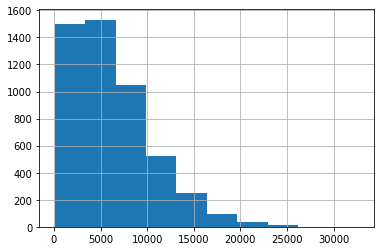

In [13]:
train['Item_Store_Returns'].hist()

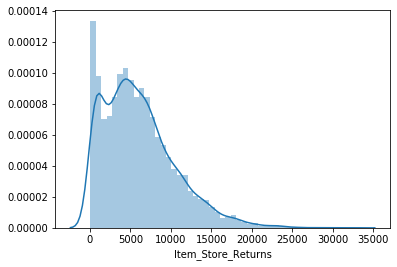

In [14]:
sns.distplot(train['Item_Store_Returns'])

In [15]:
train['Item_Store_Returns'] = np.log1p(train['Item_Store_Returns'])

In [16]:
# sns.distplot(np.exp(np.log1p(train['Item_Store_Returns'])))

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Item_ID              4990 non-null   object 
 1   Store_ID             4990 non-null   object 
 2   Item_Weight          4188 non-null   float64
 3   Item_Sugar_Content   4990 non-null   object 
 4   Item_Visibility      4990 non-null   float64
 5   Item_Type            4990 non-null   object 
 6   Item_Price           4990 non-null   float64
 7   Store_Start_Year     4990 non-null   int64  
 8   Store_Size           3540 non-null   object 
 9   Store_Location_Type  4990 non-null   object 
 10  Store_Type           4990 non-null   object 
 11  Item_Store_Returns   4990 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 467.9+ KB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3532 entries, 0 to 3531
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Item_ID              3532 non-null   object 
 1   Store_ID             3532 non-null   object 
 2   Item_Weight          2871 non-null   float64
 3   Item_Sugar_Content   3532 non-null   object 
 4   Item_Visibility      3532 non-null   float64
 5   Item_Type            3532 non-null   object 
 6   Item_Price           3532 non-null   float64
 7   Store_Start_Year     3532 non-null   int64  
 8   Store_Size           2573 non-null   object 
 9   Store_Location_Type  3532 non-null   object 
 10  Store_Type           3532 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 303.7+ KB


### Replacing Missing values

In [19]:
train['Item_Weight'].fillna(train['Item_Weight'].mean(), inplace = True)
test['Item_Weight'].fillna(test['Item_Weight'].mean(), inplace = True)

In [20]:
train['Store_Size'].value_counts()

Medium    1582
Small     1364
High       594
Name: Store_Size, dtype: int64

In [21]:
test['Store_Size'].value_counts()

Medium    1211
Small     1024
High       338
Name: Store_Size, dtype: int64

In [22]:
train['Store_Size'].fillna(train['Store_Size'].mode()[0], inplace = True)
test['Store_Size'].fillna(test['Store_Size'].mode()[0], inplace = True)

In [23]:
from datetime import datetime as dt

In [24]:
train['Store_Start_Year'] = dt.today().year - train['Store_Start_Year']
test['Store_Start_Year'] = dt.today().year - test['Store_Start_Year']

In [25]:
train['Store_Start_Year'] = train['Store_Start_Year'].astype('float')
test['Store_Start_Year'] = test['Store_Start_Year'].astype('float')

In [26]:
# sns.heatmap(train.corr(), annot = True)

In [27]:
train['sqrt_Item_Price'] = np.sqrt(train['Item_Price'])
test['sqrt_Item_Price'] = np.sqrt(test['Item_Price'])


train['cross_Item_weight'] = train['Item_Price'] * train['Item_Weight']
test['cross_Item_weight'] = test['Item_Price'] * test['Item_Weight']

train['Cross_Item_visibility_weight'] = train['Item_Price'] * train['Item_Weight'] * train['Item_Visibility']
test['Cross_Item_visibility_weight'] = test['Item_Price'] * test['Item_Weight'] * test['Item_Visibility']

In [28]:
data = train.drop('Item_Store_Returns', axis = 1)
target = train['Item_Store_Returns']

In [29]:
print(data.shape)
print(target.shape)

(4990, 14)
(4990,)


In [30]:
data['Item_ID'].nunique()

1451

In [31]:
data['Store_ID'].nunique()

10

In [32]:
cat_var = np.where(data.dtypes != np.float)[0]

In [33]:
cat_var

array([ 0,  1,  3,  5,  8,  9, 10], dtype=int64)

In [35]:
kf = KFold(n_splits=30)

In [37]:
lgb = LGBMRegressor(num_leaves=200, min_data_in_leaf=3,
                    objective='regression',
                    max_depth=-1,learning_rate=0.05, 
                    boosting_type='gbdt', 
                    feature_fraction=0.60,
                    lambda_l1=1,lambda_l2=1, 
                    metric='rmse', 
                    num_iterations=4000)

xgb = XGBRegressor(n_estimators = 5000, max_depth = 30, 
                     reg_lambda = 80,random_state = 30,
                     learning_rate=0.3, gamma = 1.5)

cat = CatBoostRegressor(iterations = 50, depth = 3, learning_rate = 0.1, loss_function = 'RMSE')

In [38]:
cat_scores = []
cat_test_pred = np.zeros(len(test))
cat_train_pred = np.zeros(len(train))

for fold,(tr_in,te_in) in enumerate(kf.split(data)):
    
    print(f"==================================Fold{fold}=============================================")
    X_train,X_test = data.iloc[tr_in],data.iloc[te_in]
    y_train,y_test = target.iloc[tr_in],target.iloc[te_in]
    
    cat.fit(X_train,y_train,cat_features = cat_var, eval_set = [(X_train,y_train),(X_test,y_test)],
            early_stopping_rounds = 500)
    
    cat_scores.append(np.sqrt(mse(y_test,cat.predict(X_test))))
    
    cat_train_pred += cat.predict(data)
    cat_test_pred += cat.predict(test)

==================================Fold0=============================================
0:	learn: 0.9630136	test: 0.9626785	test1: 0.9456388	best: 0.9456388 (0)	total: 147ms	remaining: 7.21s
1:	learn: 0.9057340	test: 0.9049050	test1: 0.8867749	best: 0.8867749 (1)	total: 155ms	remaining: 3.73s
2:	learn: 0.8574242	test: 0.8574303	test1: 0.8407522	best: 0.8407522 (2)	total: 160ms	remaining: 2.51s
3:	learn: 0.8137609	test: 0.8138042	test1: 0.7964139	best: 0.7964139 (3)	total: 164ms	remaining: 1.89s
4:	learn: 0.7733169	test: 0.7734507	test1: 0.7578553	best: 0.7578553 (4)	total: 169ms	remaining: 1.52s
5:	learn: 0.7403569	test: 0.7401088	test1: 0.7243546	best: 0.7243546 (5)	total: 173ms	remaining: 1.27s
6:	learn: 0.7095918	test: 0.7093589	test1: 0.6941570	best: 0.6941570 (6)	total: 177ms	remaining: 1.09s
7:	learn: 0.6826707	test: 0.6824390	test1: 0.6673828	best: 0.6673828 (7)	total: 181ms	remaining: 950ms
8:	learn: 0.6595080	test: 0.6593401	test1: 0.6442825	best: 0.6442825 (8)	total: 189ms	remai

39:	learn: 0.5273543	test: 0.5252666	test1: 0.4757691	best: 0.4757691 (39)	total: 185ms	remaining: 46.3ms
40:	learn: 0.5271680	test: 0.5250768	test1: 0.4754564	best: 0.4754564 (40)	total: 189ms	remaining: 41.5ms
41:	learn: 0.5268225	test: 0.5247304	test1: 0.4755379	best: 0.4754564 (40)	total: 193ms	remaining: 36.7ms
42:	learn: 0.5265024	test: 0.5245410	test1: 0.4753962	best: 0.4753962 (42)	total: 196ms	remaining: 32ms
43:	learn: 0.5262871	test: 0.5243917	test1: 0.4751297	best: 0.4751297 (43)	total: 200ms	remaining: 27.3ms
44:	learn: 0.5260064	test: 0.5242002	test1: 0.4749958	best: 0.4749958 (44)	total: 204ms	remaining: 22.7ms
45:	learn: 0.5259213	test: 0.5241114	test1: 0.4750585	best: 0.4749958 (44)	total: 209ms	remaining: 18.2ms
46:	learn: 0.5255381	test: 0.5239782	test1: 0.4750433	best: 0.4749958 (44)	total: 214ms	remaining: 13.6ms
47:	learn: 0.5254367	test: 0.5238991	test1: 0.4749499	best: 0.4749499 (47)	total: 220ms	remaining: 9.18ms
48:	learn: 0.5252504	test: 0.5237019	test1: 0.47

41:	learn: 0.5262333	test: 0.5244269	test1: 0.4716924	best: 0.4714911 (40)	total: 186ms	remaining: 35.4ms
42:	learn: 0.5258905	test: 0.5241549	test1: 0.4712208	best: 0.4712208 (42)	total: 190ms	remaining: 30.9ms
43:	learn: 0.5258158	test: 0.5241012	test1: 0.4709786	best: 0.4709786 (43)	total: 194ms	remaining: 26.4ms
44:	learn: 0.5256017	test: 0.5238864	test1: 0.4706193	best: 0.4706193 (44)	total: 197ms	remaining: 21.9ms
45:	learn: 0.5253611	test: 0.5237425	test1: 0.4704494	best: 0.4704494 (45)	total: 201ms	remaining: 17.5ms
46:	learn: 0.5250602	test: 0.5234365	test1: 0.4701310	best: 0.4701310 (46)	total: 205ms	remaining: 13.1ms
47:	learn: 0.5249033	test: 0.5232988	test1: 0.4698666	best: 0.4698666 (47)	total: 209ms	remaining: 8.69ms
48:	learn: 0.5248659	test: 0.5232754	test1: 0.4698525	best: 0.4698525 (48)	total: 212ms	remaining: 4.33ms
49:	learn: 0.5248175	test: 0.5232543	test1: 0.4697660	best: 0.4697660 (49)	total: 216ms	remaining: 0us

bestTest = 0.4697659592
bestIteration = 49

====

44:	learn: 0.5265757	test: 0.5252302	test1: 0.4662000	best: 0.4662000 (44)	total: 200ms	remaining: 22.2ms
45:	learn: 0.5263641	test: 0.5250390	test1: 0.4660386	best: 0.4660386 (45)	total: 204ms	remaining: 17.7ms
46:	learn: 0.5262274	test: 0.5249305	test1: 0.4660960	best: 0.4660386 (45)	total: 208ms	remaining: 13.3ms
47:	learn: 0.5261182	test: 0.5248312	test1: 0.4660861	best: 0.4660386 (45)	total: 214ms	remaining: 8.93ms
48:	learn: 0.5259541	test: 0.5246525	test1: 0.4660022	best: 0.4660022 (48)	total: 219ms	remaining: 4.47ms
49:	learn: 0.5257762	test: 0.5245155	test1: 0.4658525	best: 0.4658525 (49)	total: 226ms	remaining: 0us

bestTest = 0.4658524914
bestIteration = 49

==================================Fold6=============================================
0:	learn: 0.9632363	test: 0.9631824	test1: 0.9290696	best: 0.9290696 (0)	total: 11.4ms	remaining: 557ms
1:	learn: 0.9058821	test: 0.9053425	test1: 0.8740214	best: 0.8740214 (1)	total: 21.3ms	remaining: 512ms
2:	learn: 0.8538573	test: 0.8

41:	learn: 0.5242645	test: 0.5220734	test1: 0.5709372	best: 0.5708749 (35)	total: 185ms	remaining: 35.1ms
42:	learn: 0.5239070	test: 0.5217206	test1: 0.5707142	best: 0.5707142 (42)	total: 189ms	remaining: 30.7ms
43:	learn: 0.5235730	test: 0.5214795	test1: 0.5704325	best: 0.5704325 (43)	total: 192ms	remaining: 26.2ms
44:	learn: 0.5234842	test: 0.5213846	test1: 0.5703728	best: 0.5703728 (44)	total: 195ms	remaining: 21.7ms
45:	learn: 0.5233589	test: 0.5212622	test1: 0.5707070	best: 0.5703728 (44)	total: 198ms	remaining: 17.2ms
46:	learn: 0.5230432	test: 0.5210333	test1: 0.5706279	best: 0.5703728 (44)	total: 202ms	remaining: 12.9ms
47:	learn: 0.5229133	test: 0.5209062	test1: 0.5709392	best: 0.5703728 (44)	total: 207ms	remaining: 8.63ms
48:	learn: 0.5229082	test: 0.5209038	test1: 0.5709645	best: 0.5703728 (44)	total: 212ms	remaining: 4.32ms
49:	learn: 0.5227710	test: 0.5207666	test1: 0.5709057	best: 0.5703728 (44)	total: 216ms	remaining: 0us

bestTest = 0.5703728105
bestIteration = 44

Shri

42:	learn: 0.5239535	test: 0.5225269	test1: 0.5282576	best: 0.5282483 (41)	total: 185ms	remaining: 30.1ms
43:	learn: 0.5236454	test: 0.5222653	test1: 0.5282211	best: 0.5282211 (43)	total: 188ms	remaining: 25.7ms
44:	learn: 0.5233284	test: 0.5219497	test1: 0.5279343	best: 0.5279343 (44)	total: 192ms	remaining: 21.3ms
45:	learn: 0.5229767	test: 0.5216044	test1: 0.5282789	best: 0.5279343 (44)	total: 196ms	remaining: 17ms
46:	learn: 0.5228552	test: 0.5215651	test1: 0.5282505	best: 0.5279343 (44)	total: 199ms	remaining: 12.7ms
47:	learn: 0.5227684	test: 0.5215352	test1: 0.5282934	best: 0.5279343 (44)	total: 203ms	remaining: 8.46ms
48:	learn: 0.5226448	test: 0.5214314	test1: 0.5281714	best: 0.5279343 (44)	total: 207ms	remaining: 4.22ms
49:	learn: 0.5225397	test: 0.5213328	test1: 0.5280365	best: 0.5279343 (44)	total: 210ms	remaining: 0us

bestTest = 0.5279343468
bestIteration = 44

Shrink model to first 45 iterations.
==================================Fold10===================================

36:	learn: 0.5256115	test: 0.5229889	test1: 0.5640452	best: 0.5640452 (36)	total: 173ms	remaining: 60.9ms
37:	learn: 0.5252660	test: 0.5226860	test1: 0.5638939	best: 0.5638939 (37)	total: 177ms	remaining: 56ms
38:	learn: 0.5249590	test: 0.5223848	test1: 0.5640295	best: 0.5638939 (37)	total: 184ms	remaining: 52ms
39:	learn: 0.5246859	test: 0.5223039	test1: 0.5638397	best: 0.5638397 (39)	total: 191ms	remaining: 47.9ms
40:	learn: 0.5244288	test: 0.5220816	test1: 0.5635136	best: 0.5635136 (40)	total: 196ms	remaining: 42.9ms
41:	learn: 0.5241255	test: 0.5218913	test1: 0.5627620	best: 0.5627620 (41)	total: 199ms	remaining: 38ms
42:	learn: 0.5238902	test: 0.5216617	test1: 0.5631127	best: 0.5627620 (41)	total: 202ms	remaining: 32.9ms
43:	learn: 0.5234899	test: 0.5212715	test1: 0.5629910	best: 0.5627620 (41)	total: 207ms	remaining: 28.2ms
44:	learn: 0.5231914	test: 0.5210134	test1: 0.5633829	best: 0.5627620 (41)	total: 210ms	remaining: 23.4ms
45:	learn: 0.5230341	test: 0.5208949	test1: 0.563172

44:	learn: 0.5254984	test: 0.5240094	test1: 0.4932870	best: 0.4912785 (28)	total: 210ms	remaining: 23.3ms
45:	learn: 0.5253584	test: 0.5238528	test1: 0.4936943	best: 0.4912785 (28)	total: 214ms	remaining: 18.6ms
46:	learn: 0.5252357	test: 0.5237330	test1: 0.4939142	best: 0.4912785 (28)	total: 218ms	remaining: 13.9ms
47:	learn: 0.5249783	test: 0.5235091	test1: 0.4942275	best: 0.4912785 (28)	total: 223ms	remaining: 9.31ms
48:	learn: 0.5247860	test: 0.5233544	test1: 0.4943087	best: 0.4912785 (28)	total: 230ms	remaining: 4.7ms
49:	learn: 0.5245992	test: 0.5232508	test1: 0.4943706	best: 0.4912785 (28)	total: 236ms	remaining: 0us

bestTest = 0.4912785055
bestIteration = 28

Shrink model to first 29 iterations.
==================================Fold14=============================================
0:	learn: 0.9617154	test: 0.9615294	test1: 1.0115587	best: 1.0115587 (0)	total: 9.49ms	remaining: 465ms
1:	learn: 0.9026181	test: 0.9022280	test1: 0.9472341	best: 0.9472341 (1)	total: 13.4ms	remaining

42:	learn: 0.5232531	test: 0.5219158	test1: 0.5451082	best: 0.5449382 (41)	total: 196ms	remaining: 31.9ms
43:	learn: 0.5230193	test: 0.5217087	test1: 0.5448230	best: 0.5448230 (43)	total: 202ms	remaining: 27.6ms
44:	learn: 0.5229198	test: 0.5216444	test1: 0.5446305	best: 0.5446305 (44)	total: 207ms	remaining: 23ms
45:	learn: 0.5227403	test: 0.5214554	test1: 0.5446470	best: 0.5446305 (44)	total: 214ms	remaining: 18.6ms
46:	learn: 0.5225507	test: 0.5212646	test1: 0.5447294	best: 0.5446305 (44)	total: 218ms	remaining: 13.9ms
47:	learn: 0.5224737	test: 0.5212256	test1: 0.5447174	best: 0.5446305 (44)	total: 221ms	remaining: 9.23ms
48:	learn: 0.5224281	test: 0.5211907	test1: 0.5447231	best: 0.5446305 (44)	total: 226ms	remaining: 4.6ms
49:	learn: 0.5224011	test: 0.5211771	test1: 0.5447938	best: 0.5446305 (44)	total: 230ms	remaining: 0us

bestTest = 0.5446305093
bestIteration = 44

Shrink model to first 45 iterations.
==================================Fold16====================================

40:	learn: 0.5253561	test: 0.5234370	test1: 0.5159694	best: 0.5159694 (40)	total: 186ms	remaining: 40.9ms
41:	learn: 0.5250626	test: 0.5231782	test1: 0.5163663	best: 0.5159694 (40)	total: 192ms	remaining: 36.6ms
42:	learn: 0.5249119	test: 0.5230320	test1: 0.5166746	best: 0.5159694 (40)	total: 197ms	remaining: 32.1ms
43:	learn: 0.5245966	test: 0.5227694	test1: 0.5169239	best: 0.5159694 (40)	total: 203ms	remaining: 27.7ms
44:	learn: 0.5243823	test: 0.5225799	test1: 0.5169652	best: 0.5159694 (40)	total: 207ms	remaining: 23ms
45:	learn: 0.5242473	test: 0.5224946	test1: 0.5168437	best: 0.5159694 (40)	total: 211ms	remaining: 18.3ms
46:	learn: 0.5240846	test: 0.5223985	test1: 0.5172106	best: 0.5159694 (40)	total: 215ms	remaining: 13.7ms
47:	learn: 0.5238470	test: 0.5221936	test1: 0.5180529	best: 0.5159694 (40)	total: 219ms	remaining: 9.12ms
48:	learn: 0.5238284	test: 0.5221935	test1: 0.5180503	best: 0.5159694 (40)	total: 222ms	remaining: 4.54ms
49:	learn: 0.5237713	test: 0.5221372	test1: 0.51

38:	learn: 0.5252804	test: 0.5227580	test1: 0.5464769	best: 0.5463246 (37)	total: 171ms	remaining: 48.2ms
39:	learn: 0.5249875	test: 0.5225838	test1: 0.5464494	best: 0.5463246 (37)	total: 176ms	remaining: 44.1ms
40:	learn: 0.5246650	test: 0.5222723	test1: 0.5457508	best: 0.5457508 (40)	total: 183ms	remaining: 40.1ms
41:	learn: 0.5244396	test: 0.5220406	test1: 0.5455248	best: 0.5455248 (41)	total: 188ms	remaining: 35.7ms
42:	learn: 0.5241043	test: 0.5217603	test1: 0.5459317	best: 0.5455248 (41)	total: 192ms	remaining: 31.2ms
43:	learn: 0.5238438	test: 0.5215676	test1: 0.5455311	best: 0.5455248 (41)	total: 195ms	remaining: 26.6ms
44:	learn: 0.5236694	test: 0.5213834	test1: 0.5452716	best: 0.5452716 (44)	total: 199ms	remaining: 22.1ms
45:	learn: 0.5233624	test: 0.5210919	test1: 0.5454024	best: 0.5452716 (44)	total: 203ms	remaining: 17.7ms
46:	learn: 0.5231091	test: 0.5208534	test1: 0.5451953	best: 0.5451953 (46)	total: 207ms	remaining: 13.2ms
47:	learn: 0.5229557	test: 0.5206970	test1: 0.

43:	learn: 0.5244395	test: 0.5232321	test1: 0.5042406	best: 0.5041765 (42)	total: 206ms	remaining: 28.1ms
44:	learn: 0.5241841	test: 0.5229902	test1: 0.5040583	best: 0.5040583 (44)	total: 210ms	remaining: 23.3ms
45:	learn: 0.5240662	test: 0.5228759	test1: 0.5037983	best: 0.5037983 (45)	total: 215ms	remaining: 18.7ms
46:	learn: 0.5239498	test: 0.5227648	test1: 0.5036643	best: 0.5036643 (46)	total: 219ms	remaining: 14ms
47:	learn: 0.5238936	test: 0.5227183	test1: 0.5035426	best: 0.5035426 (47)	total: 224ms	remaining: 9.32ms
48:	learn: 0.5237987	test: 0.5226564	test1: 0.5035041	best: 0.5035041 (48)	total: 229ms	remaining: 4.67ms
49:	learn: 0.5236299	test: 0.5225084	test1: 0.5034646	best: 0.5034646 (49)	total: 233ms	remaining: 0us

bestTest = 0.5034646183
bestIteration = 49

==================================Fold22=============================================
0:	learn: 0.9629571	test: 0.9627308	test1: 0.9754388	best: 0.9754388 (0)	total: 13.1ms	remaining: 642ms
1:	learn: 0.9035938	test: 0.

36:	learn: 0.5250520	test: 0.5233886	test1: 0.5562287	best: 0.5562287 (36)	total: 183ms	remaining: 64.2ms
37:	learn: 0.5246139	test: 0.5229764	test1: 0.5553533	best: 0.5553533 (37)	total: 187ms	remaining: 59ms
38:	learn: 0.5242270	test: 0.5225847	test1: 0.5545065	best: 0.5545065 (38)	total: 191ms	remaining: 53.8ms
39:	learn: 0.5238682	test: 0.5222398	test1: 0.5541067	best: 0.5541067 (39)	total: 195ms	remaining: 48.7ms
40:	learn: 0.5235622	test: 0.5219677	test1: 0.5538200	best: 0.5538200 (40)	total: 200ms	remaining: 43.9ms
41:	learn: 0.5235622	test: 0.5219678	test1: 0.5538215	best: 0.5538200 (40)	total: 203ms	remaining: 38.7ms
42:	learn: 0.5233568	test: 0.5217676	test1: 0.5532779	best: 0.5532779 (42)	total: 207ms	remaining: 33.7ms
43:	learn: 0.5233039	test: 0.5217676	test1: 0.5532774	best: 0.5532774 (43)	total: 213ms	remaining: 29ms
44:	learn: 0.5230358	test: 0.5215039	test1: 0.5525849	best: 0.5525849 (44)	total: 219ms	remaining: 24.3ms
45:	learn: 0.5227661	test: 0.5212575	test1: 0.5519

35:	learn: 0.5271091	test: 0.5250786	test1: 0.5041886	best: 0.5039984 (31)	total: 180ms	remaining: 70.1ms
36:	learn: 0.5267263	test: 0.5247153	test1: 0.5042129	best: 0.5039984 (31)	total: 185ms	remaining: 64.9ms
37:	learn: 0.5264213	test: 0.5244276	test1: 0.5044536	best: 0.5039984 (31)	total: 190ms	remaining: 60ms
38:	learn: 0.5261092	test: 0.5241621	test1: 0.5049295	best: 0.5039984 (31)	total: 195ms	remaining: 54.9ms
39:	learn: 0.5259375	test: 0.5240292	test1: 0.5045607	best: 0.5039984 (31)	total: 200ms	remaining: 49.9ms
40:	learn: 0.5255295	test: 0.5236733	test1: 0.5039028	best: 0.5039028 (40)	total: 204ms	remaining: 44.8ms
41:	learn: 0.5253274	test: 0.5234990	test1: 0.5038511	best: 0.5038511 (41)	total: 208ms	remaining: 39.6ms
42:	learn: 0.5250799	test: 0.5234016	test1: 0.5035662	best: 0.5035662 (42)	total: 212ms	remaining: 34.5ms
43:	learn: 0.5247641	test: 0.5231258	test1: 0.5030275	best: 0.5030275 (43)	total: 217ms	remaining: 29.6ms
44:	learn: 0.5245667	test: 0.5229423	test1: 0.50

37:	learn: 0.5283147	test: 0.5262560	test1: 0.4765142	best: 0.4765142 (37)	total: 183ms	remaining: 57.9ms
38:	learn: 0.5278889	test: 0.5258601	test1: 0.4763805	best: 0.4763805 (38)	total: 187ms	remaining: 52.8ms
39:	learn: 0.5277195	test: 0.5256995	test1: 0.4763117	best: 0.4763117 (39)	total: 191ms	remaining: 47.7ms
40:	learn: 0.5272742	test: 0.5252866	test1: 0.4756463	best: 0.4756463 (40)	total: 195ms	remaining: 42.9ms
41:	learn: 0.5269716	test: 0.5250788	test1: 0.4755210	best: 0.4755210 (41)	total: 199ms	remaining: 38ms
42:	learn: 0.5267578	test: 0.5248646	test1: 0.4747813	best: 0.4747813 (42)	total: 202ms	remaining: 32.9ms
43:	learn: 0.5265675	test: 0.5247173	test1: 0.4749358	best: 0.4747813 (42)	total: 206ms	remaining: 28.1ms
44:	learn: 0.5265031	test: 0.5246508	test1: 0.4748309	best: 0.4747813 (42)	total: 210ms	remaining: 23.3ms
45:	learn: 0.5263079	test: 0.5244698	test1: 0.4738464	best: 0.4738464 (45)	total: 214ms	remaining: 18.6ms
46:	learn: 0.5259601	test: 0.5241668	test1: 0.47

40:	learn: 0.5240477	test: 0.5224692	test1: 0.5440476	best: 0.5438153 (37)	total: 186ms	remaining: 40.8ms
41:	learn: 0.5238032	test: 0.5222518	test1: 0.5440957	best: 0.5438153 (37)	total: 190ms	remaining: 36.1ms
42:	learn: 0.5236458	test: 0.5221041	test1: 0.5440489	best: 0.5438153 (37)	total: 193ms	remaining: 31.5ms
43:	learn: 0.5234164	test: 0.5219024	test1: 0.5439187	best: 0.5438153 (37)	total: 197ms	remaining: 26.9ms
44:	learn: 0.5231605	test: 0.5216516	test1: 0.5439735	best: 0.5438153 (37)	total: 201ms	remaining: 22.4ms
45:	learn: 0.5230323	test: 0.5215653	test1: 0.5441495	best: 0.5438153 (37)	total: 206ms	remaining: 17.9ms
46:	learn: 0.5229792	test: 0.5215382	test1: 0.5442345	best: 0.5438153 (37)	total: 210ms	remaining: 13.4ms
47:	learn: 0.5227549	test: 0.5213242	test1: 0.5442205	best: 0.5438153 (37)	total: 214ms	remaining: 8.91ms
48:	learn: 0.5224709	test: 0.5210512	test1: 0.5440510	best: 0.5438153 (37)	total: 218ms	remaining: 4.44ms
49:	learn: 0.5223300	test: 0.5209442	test1: 0.

In [39]:
np.mean(cat_scores)

0.5242441744250296

In [40]:
final = cat_test_pred/30

In [45]:
feat_import = pd.Series(cat.feature_importances_, index = data.columns)
feat_import

Item_ID                          0.000000
Store_ID                        21.947238
Item_Weight                      0.041798
Item_Sugar_Content               0.027626
Item_Visibility                  0.000000
Item_Type                        0.003160
Item_Price                      11.179807
Store_Start_Year                 1.690942
Store_Size                       0.247859
Store_Location_Type              0.048267
Store_Type                      55.537481
sqrt_Item_Price                  8.998568
cross_Item_weight                0.138427
Cross_Item_visibility_weight     0.138827
dtype: float64

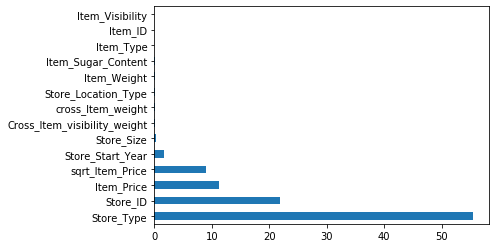

In [46]:
feat_import = pd.Series(cat.feature_importances_, index = data.columns)
feat_import.sort_values(ascending = True).nlargest(20).plot(kind = 'barh')

In [47]:
data2 = data.drop(['Item_ID', 'Item_Visibility'], axis = 1)

In [51]:
test2 = test.drop(['Item_ID', 'Item_Visibility'], axis = 1)

In [53]:
cat_var2 = np.where(data2.dtypes != np.float)[0]

In [54]:
cat3 = CatBoostRegressor(iterations = 50, depth = 3, learning_rate = 0.1, loss_function = 'RMSE')
# cat3.fit(X_train, y_train, cat_features = cat_var2, eval_set = (X_test, y_test))

In [58]:
cat_scores = []
cat_test_pred = np.zeros(len(test2))
cat_train_pred = np.zeros(len(data2))

for fold,(tr_in,te_in) in enumerate(kf.split(data2)):
    
    print(f"==================================Fold{fold}=============================================")
    X_train,X_test = data2.iloc[tr_in],data2.iloc[te_in]
    y_train,y_test = target.iloc[tr_in],target.iloc[te_in]
    
    cat3.fit(X_train,y_train,cat_features = cat_var2, eval_set = [(X_train,y_train),(X_test,y_test)],
            early_stopping_rounds = 500)
    
    cat_scores.append(np.sqrt(mse(y_test,cat3.predict(X_test))))
    
    cat_train_pred += cat3.predict(data2)
    cat_test_pred += cat3.predict(test2)

==================================Fold0=============================================
0:	learn: 0.9620414	test: 0.9605986	test1: 0.9441841	best: 0.9441841 (0)	total: 12.6ms	remaining: 617ms
1:	learn: 0.9036565	test: 0.9020446	test1: 0.8854866	best: 0.8854866 (1)	total: 20.9ms	remaining: 501ms
2:	learn: 0.8520258	test: 0.8496137	test1: 0.8339281	best: 0.8339281 (2)	total: 29.1ms	remaining: 456ms
3:	learn: 0.8060543	test: 0.8032563	test1: 0.7886956	best: 0.7886956 (3)	total: 32.9ms	remaining: 378ms
4:	learn: 0.7660206	test: 0.7631779	test1: 0.7492019	best: 0.7492019 (4)	total: 36.5ms	remaining: 328ms
5:	learn: 0.7311763	test: 0.7282605	test1: 0.7151528	best: 0.7151528 (5)	total: 40.1ms	remaining: 294ms
6:	learn: 0.7011185	test: 0.6980752	test1: 0.6853069	best: 0.6853069 (6)	total: 44ms	remaining: 270ms
7:	learn: 0.6751181	test: 0.6722813	test1: 0.6613413	best: 0.6613413 (7)	total: 47.4ms	remaining: 249ms
8:	learn: 0.6531264	test: 0.6502448	test1: 0.6408528	best: 0.6408528 (8)	total: 50.9m

45:	learn: 0.5255272	test: 0.5231095	test1: 0.4723706	best: 0.4723706 (45)	total: 197ms	remaining: 17.2ms
46:	learn: 0.5253199	test: 0.5229249	test1: 0.4718931	best: 0.4718931 (46)	total: 204ms	remaining: 13ms
47:	learn: 0.5251986	test: 0.5227917	test1: 0.4718114	best: 0.4718114 (47)	total: 208ms	remaining: 8.65ms
48:	learn: 0.5249976	test: 0.5226329	test1: 0.4718347	best: 0.4718114 (47)	total: 213ms	remaining: 4.34ms
49:	learn: 0.5249180	test: 0.5226061	test1: 0.4717739	best: 0.4717739 (49)	total: 218ms	remaining: 0us

bestTest = 0.4717739186
bestIteration = 49

==================================Fold2=============================================
0:	learn: 0.9614747	test: 0.9639321	test1: 0.9768822	best: 0.9768822 (0)	total: 9.08ms	remaining: 445ms
1:	learn: 0.9029718	test: 0.9052803	test1: 0.9214865	best: 0.9214865 (1)	total: 16.8ms	remaining: 403ms
2:	learn: 0.8513079	test: 0.8526452	test1: 0.8719034	best: 0.8719034 (2)	total: 24.6ms	remaining: 385ms
3:	learn: 0.8051333	test: 0.80623

==================================Fold4=============================================
0:	learn: 0.9623009	test: 0.9599308	test1: 0.9614267	best: 0.9614267 (0)	total: 10ms	remaining: 491ms
1:	learn: 0.9039693	test: 0.9014264	test1: 0.9019103	best: 0.9019103 (1)	total: 18.3ms	remaining: 440ms
2:	learn: 0.8535325	test: 0.8501375	test1: 0.8485997	best: 0.8485997 (2)	total: 26.1ms	remaining: 409ms
3:	learn: 0.8081572	test: 0.8047742	test1: 0.8005656	best: 0.8005656 (3)	total: 30ms	remaining: 345ms
4:	learn: 0.7682459	test: 0.7648107	test1: 0.7563377	best: 0.7563377 (4)	total: 34.2ms	remaining: 307ms
5:	learn: 0.7334441	test: 0.7299356	test1: 0.7210568	best: 0.7210568 (5)	total: 38ms	remaining: 279ms
6:	learn: 0.7032895	test: 0.6996622	test1: 0.6914020	best: 0.6914020 (6)	total: 41.8ms	remaining: 257ms
7:	learn: 0.6774182	test: 0.6740178	test1: 0.6615899	best: 0.6615899 (7)	total: 47ms	remaining: 247ms
8:	learn: 0.6549825	test: 0.6515982	test1: 0.6376787	best: 0.6376787 (8)	total: 51.7ms	rema

49:	learn: 0.5244918	test: 0.5224845	test1: 0.4628813	best: 0.4628813 (49)	total: 208ms	remaining: 0us

bestTest = 0.4628812525
bestIteration = 49

==================================Fold6=============================================
0:	learn: 0.9620211	test: 0.9613784	test1: 0.9283640	best: 0.9283640 (0)	total: 9.82ms	remaining: 481ms
1:	learn: 0.9034474	test: 0.9026412	test1: 0.8733917	best: 0.8733917 (1)	total: 17.9ms	remaining: 430ms
2:	learn: 0.8527253	test: 0.8510853	test1: 0.8233232	best: 0.8233232 (2)	total: 26.9ms	remaining: 422ms
3:	learn: 0.8071510	test: 0.8054450	test1: 0.7809813	best: 0.7809813 (3)	total: 30.7ms	remaining: 353ms
4:	learn: 0.7667901	test: 0.7650353	test1: 0.7410578	best: 0.7410578 (4)	total: 34.4ms	remaining: 310ms
5:	learn: 0.7317736	test: 0.7299466	test1: 0.7053639	best: 0.7053639 (5)	total: 38.8ms	remaining: 285ms
6:	learn: 0.7016310	test: 0.6996857	test1: 0.6741934	best: 0.6741934 (6)	total: 42.4ms	remaining: 260ms
7:	learn: 0.6756953	test: 0.6738588	tes

==================================Fold8=============================================
0:	learn: 0.9619651	test: 0.9642241	test1: 0.9589843	best: 0.9589843 (0)	total: 9.15ms	remaining: 448ms
1:	learn: 0.9034394	test: 0.9055272	test1: 0.9025532	best: 0.9025532 (1)	total: 18.7ms	remaining: 448ms
2:	learn: 0.8510956	test: 0.8529176	test1: 0.8514083	best: 0.8514083 (2)	total: 29.2ms	remaining: 457ms
3:	learn: 0.8047073	test: 0.8065034	test1: 0.8091027	best: 0.8091027 (3)	total: 34.3ms	remaining: 394ms
4:	learn: 0.7645046	test: 0.7662324	test1: 0.7724699	best: 0.7724699 (4)	total: 38.4ms	remaining: 346ms
5:	learn: 0.7296684	test: 0.7313684	test1: 0.7420406	best: 0.7420406 (5)	total: 42.4ms	remaining: 311ms
6:	learn: 0.6996694	test: 0.7012034	test1: 0.7167868	best: 0.7167868 (6)	total: 48ms	remaining: 295ms
7:	learn: 0.6738345	test: 0.6752742	test1: 0.6923833	best: 0.6923833 (7)	total: 52ms	remaining: 273ms
8:	learn: 0.6518800	test: 0.6529874	test1: 0.6716646	best: 0.6716646 (8)	total: 55.6ms	

41:	learn: 0.5242050	test: 0.5214100	test1: 0.5284089	best: 0.5284089 (41)	total: 177ms	remaining: 33.7ms
42:	learn: 0.5240219	test: 0.5212240	test1: 0.5284597	best: 0.5284089 (41)	total: 180ms	remaining: 29.3ms
43:	learn: 0.5236423	test: 0.5209027	test1: 0.5284640	best: 0.5284089 (41)	total: 185ms	remaining: 25.2ms
44:	learn: 0.5234759	test: 0.5208188	test1: 0.5284198	best: 0.5284089 (41)	total: 190ms	remaining: 21.1ms
45:	learn: 0.5233467	test: 0.5207004	test1: 0.5280637	best: 0.5280637 (45)	total: 194ms	remaining: 16.8ms
46:	learn: 0.5231673	test: 0.5205270	test1: 0.5281713	best: 0.5280637 (45)	total: 199ms	remaining: 12.7ms
47:	learn: 0.5230413	test: 0.5204106	test1: 0.5279065	best: 0.5279065 (47)	total: 203ms	remaining: 8.44ms
48:	learn: 0.5229264	test: 0.5203766	test1: 0.5279267	best: 0.5279065 (47)	total: 206ms	remaining: 4.2ms
49:	learn: 0.5227812	test: 0.5202703	test1: 0.5279059	best: 0.5279059 (49)	total: 209ms	remaining: 0us

bestTest = 0.5279058618
bestIteration = 49

=====

39:	learn: 0.5245435	test: 0.5218407	test1: 0.5605829	best: 0.5605829 (39)	total: 174ms	remaining: 43.5ms
40:	learn: 0.5243527	test: 0.5216941	test1: 0.5606372	best: 0.5605829 (39)	total: 178ms	remaining: 39.2ms
41:	learn: 0.5239741	test: 0.5213214	test1: 0.5608003	best: 0.5605829 (39)	total: 182ms	remaining: 34.7ms
42:	learn: 0.5238016	test: 0.5211350	test1: 0.5602556	best: 0.5602556 (42)	total: 187ms	remaining: 30.4ms
43:	learn: 0.5236636	test: 0.5210281	test1: 0.5603045	best: 0.5602556 (42)	total: 192ms	remaining: 26.2ms
44:	learn: 0.5235193	test: 0.5209970	test1: 0.5601917	best: 0.5601917 (44)	total: 196ms	remaining: 21.7ms
45:	learn: 0.5234630	test: 0.5209745	test1: 0.5600006	best: 0.5600006 (45)	total: 199ms	remaining: 17.3ms
46:	learn: 0.5232052	test: 0.5208292	test1: 0.5602744	best: 0.5600006 (45)	total: 203ms	remaining: 12.9ms
47:	learn: 0.5231953	test: 0.5208292	test1: 0.5602752	best: 0.5600006 (45)	total: 207ms	remaining: 8.63ms
48:	learn: 0.5229907	test: 0.5206524	test1: 0.

43:	learn: 0.5254782	test: 0.5229383	test1: 0.4973531	best: 0.4948621 (30)	total: 192ms	remaining: 26.2ms
44:	learn: 0.5253016	test: 0.5229076	test1: 0.4974541	best: 0.4948621 (30)	total: 196ms	remaining: 21.8ms
45:	learn: 0.5252756	test: 0.5228868	test1: 0.4975311	best: 0.4948621 (30)	total: 200ms	remaining: 17.4ms
46:	learn: 0.5250748	test: 0.5228689	test1: 0.4976075	best: 0.4948621 (30)	total: 204ms	remaining: 13ms
47:	learn: 0.5249689	test: 0.5228518	test1: 0.4976759	best: 0.4948621 (30)	total: 212ms	remaining: 8.85ms
48:	learn: 0.5248090	test: 0.5227545	test1: 0.4980174	best: 0.4948621 (30)	total: 216ms	remaining: 4.4ms
49:	learn: 0.5247518	test: 0.5226904	test1: 0.4982790	best: 0.4948621 (30)	total: 219ms	remaining: 0us

bestTest = 0.494862085
bestIteration = 30

Shrink model to first 31 iterations.
==================================Fold14=============================================
0:	learn: 0.9594639	test: 0.9592573	test1: 1.0070499	best: 1.0070499 (0)	total: 9.02ms	remaining:

==================================Fold16=============================================
0:	learn: 0.9601168	test: 0.9597066	test1: 0.9910206	best: 0.9910206 (0)	total: 9.31ms	remaining: 456ms
1:	learn: 0.9006592	test: 0.9001631	test1: 0.9330770	best: 0.9330770 (1)	total: 13ms	remaining: 311ms
2:	learn: 0.8479677	test: 0.8471776	test1: 0.8812167	best: 0.8812167 (2)	total: 21.1ms	remaining: 331ms
3:	learn: 0.8054649	test: 0.8042554	test1: 0.8369710	best: 0.8369710 (3)	total: 24.8ms	remaining: 285ms
4:	learn: 0.7660558	test: 0.7644760	test1: 0.7963096	best: 0.7963096 (4)	total: 28.5ms	remaining: 257ms
5:	learn: 0.7324841	test: 0.7308212	test1: 0.7622093	best: 0.7622093 (5)	total: 36.5ms	remaining: 268ms
6:	learn: 0.7028523	test: 0.7012549	test1: 0.7284040	best: 0.7284040 (6)	total: 40.2ms	remaining: 247ms
7:	learn: 0.6765916	test: 0.6749523	test1: 0.7008758	best: 0.7008758 (7)	total: 43.8ms	remaining: 230ms
8:	learn: 0.6534717	test: 0.6517987	test1: 0.6760399	best: 0.6760399 (8)	total: 47.6

==================================Fold18=============================================
0:	learn: 0.9596781	test: 0.9592284	test1: 0.9999525	best: 0.9999525 (0)	total: 9.17ms	remaining: 449ms
1:	learn: 0.8999592	test: 0.8994029	test1: 0.9383624	best: 0.9383624 (1)	total: 12.7ms	remaining: 305ms
2:	learn: 0.8472455	test: 0.8463554	test1: 0.8853578	best: 0.8853578 (2)	total: 20.6ms	remaining: 323ms
3:	learn: 0.8044666	test: 0.8031056	test1: 0.8430721	best: 0.8430721 (3)	total: 24.4ms	remaining: 280ms
4:	learn: 0.7649346	test: 0.7631243	test1: 0.8037377	best: 0.8037377 (4)	total: 28.1ms	remaining: 253ms
5:	learn: 0.7310749	test: 0.7291487	test1: 0.7716229	best: 0.7716229 (5)	total: 36ms	remaining: 264ms
6:	learn: 0.7010446	test: 0.6991320	test1: 0.7451410	best: 0.7451410 (6)	total: 39.7ms	remaining: 244ms
7:	learn: 0.6745752	test: 0.6725921	test1: 0.7199851	best: 0.7199851 (7)	total: 43.5ms	remaining: 228ms
8:	learn: 0.6514963	test: 0.6494518	test1: 0.6991566	best: 0.6991566 (8)	total: 47.2

==================================Fold20=============================================
0:	learn: 0.9607368	test: 0.9602898	test1: 0.9773123	best: 0.9773123 (0)	total: 8.8ms	remaining: 431ms
1:	learn: 0.9014217	test: 0.9008659	test1: 0.9169266	best: 0.9169266 (1)	total: 12.4ms	remaining: 297ms
2:	learn: 0.8489354	test: 0.8480474	test1: 0.8617547	best: 0.8617547 (2)	total: 21.1ms	remaining: 331ms
3:	learn: 0.8066343	test: 0.8052234	test1: 0.8152083	best: 0.8152083 (3)	total: 25.2ms	remaining: 290ms
4:	learn: 0.7673074	test: 0.7654495	test1: 0.7741481	best: 0.7741481 (4)	total: 29ms	remaining: 261ms
5:	learn: 0.7336813	test: 0.7317354	test1: 0.7391280	best: 0.7391280 (5)	total: 37.8ms	remaining: 277ms
6:	learn: 0.7038699	test: 0.7018911	test1: 0.7069379	best: 0.7069379 (6)	total: 41.5ms	remaining: 255ms
7:	learn: 0.6776749	test: 0.6756267	test1: 0.6783356	best: 0.6783356 (7)	total: 45.5ms	remaining: 239ms
8:	learn: 0.6545787	test: 0.6524702	test1: 0.6543110	best: 0.6543110 (8)	total: 50.3m

==================================Fold22=============================================
0:	learn: 0.9608447	test: 0.9603970	test1: 0.9702676	best: 0.9702676 (0)	total: 8.97ms	remaining: 439ms
1:	learn: 0.9015963	test: 0.9010589	test1: 0.9082755	best: 0.9082755 (1)	total: 12.5ms	remaining: 300ms
2:	learn: 0.8490883	test: 0.8482203	test1: 0.8531615	best: 0.8531615 (2)	total: 20.4ms	remaining: 319ms
3:	learn: 0.8066451	test: 0.8053097	test1: 0.8077900	best: 0.8077900 (3)	total: 24.2ms	remaining: 278ms
4:	learn: 0.7673606	test: 0.7655781	test1: 0.7653119	best: 0.7653119 (4)	total: 27.9ms	remaining: 251ms
5:	learn: 0.7336606	test: 0.7317671	test1: 0.7298157	best: 0.7298157 (5)	total: 36ms	remaining: 264ms
6:	learn: 0.7038612	test: 0.7019412	test1: 0.6945734	best: 0.6945734 (6)	total: 40.7ms	remaining: 250ms
7:	learn: 0.6776455	test: 0.6756597	test1: 0.6649721	best: 0.6649721 (7)	total: 44.7ms	remaining: 235ms
8:	learn: 0.6545680	test: 0.6525116	test1: 0.6384706	best: 0.6384706 (8)	total: 48.7

39:	learn: 0.5247380	test: 0.5220061	test1: 0.5607317	best: 0.5607317 (39)	total: 166ms	remaining: 41.4ms
40:	learn: 0.5245220	test: 0.5217919	test1: 0.5603979	best: 0.5603979 (40)	total: 171ms	remaining: 37.6ms
41:	learn: 0.5243004	test: 0.5215904	test1: 0.5595928	best: 0.5595928 (41)	total: 176ms	remaining: 33.4ms
42:	learn: 0.5240464	test: 0.5213494	test1: 0.5591736	best: 0.5591736 (42)	total: 181ms	remaining: 29.4ms
43:	learn: 0.5239693	test: 0.5212777	test1: 0.5586276	best: 0.5586276 (43)	total: 184ms	remaining: 25.2ms
44:	learn: 0.5237793	test: 0.5211824	test1: 0.5582737	best: 0.5582737 (44)	total: 188ms	remaining: 20.9ms
45:	learn: 0.5234693	test: 0.5210424	test1: 0.5579748	best: 0.5579748 (45)	total: 192ms	remaining: 16.7ms
46:	learn: 0.5231994	test: 0.5208128	test1: 0.5574784	best: 0.5574784 (46)	total: 195ms	remaining: 12.5ms
47:	learn: 0.5230395	test: 0.5207036	test1: 0.5571506	best: 0.5571506 (47)	total: 199ms	remaining: 8.29ms
48:	learn: 0.5229198	test: 0.5205977	test1: 0.

==================================Fold26=============================================
0:	learn: 0.9665779	test: 0.9660601	test1: 0.7836127	best: 0.7836127 (0)	total: 8.96ms	remaining: 439ms
1:	learn: 0.9067731	test: 0.9061984	test1: 0.7317018	best: 0.7317018 (1)	total: 12.6ms	remaining: 302ms
2:	learn: 0.8539052	test: 0.8529501	test1: 0.6854542	best: 0.6854542 (2)	total: 20.8ms	remaining: 326ms
3:	learn: 0.8109173	test: 0.8095418	test1: 0.6476380	best: 0.6476380 (3)	total: 24.3ms	remaining: 280ms
4:	learn: 0.7712102	test: 0.7694199	test1: 0.6124806	best: 0.6124806 (4)	total: 27.8ms	remaining: 250ms
5:	learn: 0.7375147	test: 0.7355990	test1: 0.5844859	best: 0.5844859 (5)	total: 35.7ms	remaining: 262ms
6:	learn: 0.7074549	test: 0.7054351	test1: 0.5592524	best: 0.5592524 (6)	total: 39.8ms	remaining: 244ms
7:	learn: 0.6805841	test: 0.6784702	test1: 0.5362415	best: 0.5362415 (7)	total: 43.4ms	remaining: 228ms
8:	learn: 0.6574929	test: 0.6552438	test1: 0.5178149	best: 0.5178149 (8)	total: 47

==================================Fold28=============================================
0:	learn: 0.9610403	test: 0.9605219	test1: 0.9726748	best: 0.9726748 (0)	total: 9.23ms	remaining: 452ms
1:	learn: 0.9016598	test: 0.9010848	test1: 0.9166097	best: 0.9166097 (1)	total: 12.8ms	remaining: 308ms
2:	learn: 0.8490384	test: 0.8480829	test1: 0.8660455	best: 0.8660455 (2)	total: 20.7ms	remaining: 325ms
3:	learn: 0.8063838	test: 0.8050055	test1: 0.8237391	best: 0.8237391 (3)	total: 24.5ms	remaining: 282ms
4:	learn: 0.7669582	test: 0.7651637	test1: 0.7856206	best: 0.7856206 (4)	total: 28.2ms	remaining: 254ms
5:	learn: 0.7334435	test: 0.7315363	test1: 0.7539901	best: 0.7539901 (5)	total: 39.4ms	remaining: 289ms
6:	learn: 0.7033420	test: 0.7013166	test1: 0.7240794	best: 0.7240794 (6)	total: 43.4ms	remaining: 267ms
7:	learn: 0.6771457	test: 0.6750249	test1: 0.6981944	best: 0.6981944 (7)	total: 47.5ms	remaining: 249ms
8:	learn: 0.6543622	test: 0.6521736	test1: 0.6752874	best: 0.6752874 (8)	total: 51

In [60]:
np.mean(cat_scores)

0.5230481958221145

In [61]:
final = cat_test_pred/30

In [63]:
sub2 = pd.DataFrame(final, columns = ['Item_Store_Returns'])

In [64]:
sub2.head()

,Item_Store_Returns
0,6.849220
1,8.777779
2,8.797124
3,6.866719
4,8.787004


In [65]:
sub2['Item_Store_Returns'] = round(np.exp(sub2['Item_Store_Returns'])).astype('int')

In [66]:
sub2.head()

,Item_Store_Returns
0,943
1,6488
2,6615
3,960
4,6549


In [67]:
submission = pd.concat([submit, sub2], axis = 1)

In [68]:
submission.head()

,Item_Store_ID,Item_Store_Returns
0,DRA59_BABATUNJI010,943
1,DRA59_BABATUNJI013,6488
2,DRB01_BABATUNJI013,6615
3,DRB13_BABATUNJI010,960
4,DRB13_BABATUNJI013,6549


In [69]:
submission.shape

(3532, 2)

In [70]:
submission.to_csv('My_submission2a.csv', index = False)